# NIM : 2440011955, Name : Czar Kevin Sanjaya Soecahyo, Class : LB01, UAS : Nomor 2

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

import string

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers
import tensorflow as tf

Langkah pertama adalah melakukan import library yang dibutuhkan untuk mengerjakan soal ini. Pandas dan numpy adalah library default, sklearn untuk melakukan splitting data, encoder, dan membuat confusion matrix, keras digunakan untuk membuat model.

## 2. a) Lakukan proses preprocess dan prepare dataset, Jelaskan setiap step yang dilakukan disertai dengan konsep-konsep dalam NLP

In [2]:
data_df = pd.read_csv('/kaggle/input/clickbait/clickbait-uas-no2.csv')

Langkah pertama adalah melakukan import dataset yang dipakai.

In [3]:
print (data_df.head())

                                            headline  clickbait
0                                 Should I Get Bings          1
1      Which TV Female Friend Group Do You Belong In          1
2  The New "Star Wars: The Force Awakens" Trailer...          1
3  This Vine Of New York On "Celebrity Big Brothe...          1
4  A Couple Did A Stunning Photo Shoot With Their...          1


Kemudian mengecek bagaimana bentuk dari dataset

In [4]:
print(data_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headline   32000 non-null  object
 1   clickbait  32000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 500.1+ KB
None


Kemudian menunjukkan info dari dataset

In [5]:
print(data_df['clickbait'].value_counts())

0    16001
1    15999
Name: clickbait, dtype: int64


Melakukan printing jumlah clickbait 0 dan clickbait 1 pada dataset

In [6]:
print(data_df.isna().sum())

headline     0
clickbait    0
dtype: int64


Mengecek apakah ada data yang kosong pada dataset. Apabila ada, maka data akan di drop. Karena tidak ada data yang kosong, maka tidak perlu dilakukan drop data.

In [7]:
data_df.drop_duplicates(inplace=True)

Kemudian supaya tidak redundan, apabila ada data yang duplicate, maka perlu di drop juga.

In [8]:
def lowercasing(lst):
    new_list=[]
    
    for i in lst:
        i = str(i).lower()
        new_list.append(i)
    return new_list

data_df = data_df.apply (lowercasing) 

Kolom headline yang ada pada dataset akan diubah ke lowercase untuk menghindari adanya ambiguitas antara kata seperti tv, Tv, dan TV.

In [9]:
def remove_punctuations(lst):
    new_list=[]
    
    for i in lst:
        i = i.translate (str.maketrans('', '', string.punctuation))
        new_list.append(i)
    return new_list

data_df = data_df.apply (remove_punctuations) 

Kolom headline yang ada pada dataset juga akan dihilangkan pungtuasinya untuk meningkatkan efisiensi dari model. Punktuasi ini dapat dihilangkan karena tidak akan memberi informasi apa-apa pada model yang akan dibuat.

Contoh pungtuasi / tanda baca adalah
- Tanda Titik (.)
- Tanda Koma (,)
- Tanda Titik Koma (;)
- Tanda Titik Dua (:)
- Tanda Hubung (-)
- Tanda Pisah (―)
- Tanda Elipsis (...)
- Tanda Tanya (?)

In [10]:
def remove_spaces(lst):
    new_list=[]
    
    for i in lst:
        i=i.strip()
        new_list.append(i)
    return new_list

data_df = data_df.apply (remove_spaces)

Karena pada saat penghapusan tanda baca dapat menyebabkan adanya tambahan white space pada dataset yang akan menyebabkan redundansi pada dataset.

In [11]:
print (data_df.head())

                                            headline clickbait
0                                 should i get bings         1
1      which tv female friend group do you belong in         1
2  the new star wars the force awakens trailer is...         1
3  this vine of new york on celebrity big brother...         1
4  a couple did a stunning photo shoot with their...         1


Kemudian akan diprint hasil dari dataset yang sudah dipraproses sebelumnya, dapat dilihat bahwa pada headline sudah lowercase dan tanda baca.

Sebenarnya ada praproses lain yang dapat dilakukan, yaitu melakukan stemming, menghilangkan stopwords, dan menghilangkan angka. Ketiga praproses tersebut tidak saya lakukan karena :

- Pada stemming, saya tidak menemukan algoritma yang cukup bagus untuk melakukan stemming
- Pada stopwords, saya tidak menghilangkan stopword karena terlalu banyak informasi yang hilang pada headline apabila stopwordnya dihilangkan
- Pada angka, memang biasanya dihilangkan pada text classification karena tidak memberikan informasi apa-apa. Tetapi, pada dataset headline ini, angka yang besar bisa memberikan efek hiperbola untuk melebih-lebihkan judul suatu berita. Maka angka tidak akan saya hilangkan pada dataset

In [12]:
text = data_df['headline'].values
labels = data_df['clickbait'].values

x_train, x_test, y_train, y_test = train_test_split(text, labels, random_state=0, train_size = .80)
x_test, x_val, y_test, y_val  = train_test_split(x_test, y_test, random_state=0, train_size = 0.5)

print(x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape)

(25600,) (3200,) (3200,) (25600,) (3200,) (3200,)


Langkah berikutnya adalah melakukan spliting dataset menjadi train, test, dan validation dengan rasio  80% : 10% : 10% dengan menggunakan train_test_split.

In [13]:
vocab_size = 5000
maxlen = 500
embedding_size = 32

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(text)

X_train = tokenizer.texts_to_sequences(x_train)
x_val = tokenizer.texts_to_sequences(x_val)
x_test = tokenizer.texts_to_sequences(x_test)

X_train = pad_sequences(X_train, maxlen=maxlen)
x_val = pad_sequences(x_val, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

Langkah berikutnya adalah melakukan tokenisasi pada kolom pertama atau xsupaya dapat dimasukkan pada model. Hal ini dikarenakan model hanya dapat menerima angka.

In [14]:
x_val.shape

(3200, 500)

In [15]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)

Langkah selanjutnya adalah melakukan encoding label data karena setelah melalui praproses, kolom y kembali berubah menjadi encode sehingga perlu dilakukan encoding supaya kembali menjadi integer.

## 2. b) Buatlah arsitektur tanpa menggunakan pre-trained model untuk mengatasi problematika clickbait classification dengan menggunakan arsitektur yang tepat. Jelaskan pemilihan arsitektur yang dibuat dan konsep dasar dari arsitektur yang dipilih

In [16]:
def original_model() :
    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=maxlen))
    model.add(layers.Flatten(input_shape=(maxlen, embedding_size)))
    model.add(layers.Dense(16000, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model
model = original_model()
model.summary()

2023-02-06 13:29:17.558249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 13:29:17.559155: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 13:29:17.641373: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 13:29:17.642212: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 13:29:17.642954: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 32)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 16000)             0         
_________________________________________________________________
dense (Dense)                (None, 16000)             256016000 
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 16001     
Total params: 256,192,001
Trainable params: 256,192,001
Non-trainable params: 0
_________________________________________________________________


ysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 13:29:17.645366: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 13:29:17.908303: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 13:29:17.909207: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 13:29:17.910017: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node r

Untuk membuat model pada text classification, 

referensi yang saya gunakan adalah : https://www.kaggle.com/code/sanikamal/text-classification-with-python-and-keras

Terdapat beberapa layer dalam model yang dibuat, yaitu embedding layer, flatten layer, 2 dense layer, dimana :

1. Embedding Layer, untuk mengubah token dari dataset yang sudah ditokenisasi sebelumnya menjadii vector. input_dim adalah jumlah kata unik pada teks, output_dim adalah ukuran dari vector yang dihasilkan, dan input_length adalah jumlah maksimal panjang teks yang akan diproses. Apabila terlalu panjang, model akan kesusahan dalam melakukan training dan adanya resiko munculnya error yang tidak diinginkan sepertii vanishing gradient.

2. Flatten layer, untuk mengubah vector dari tensor menjadi array 1 dimensi.

3. Dense layer, untuk sebagai fungsi layer fully connected yang menggunakan aktivasi dari relu dan jumlah nodenya adalah 16.000. Kemudian pada dense layer kedua akan digunakan sebagai layer output dengan aktivasi sigmoid dengan 1 node yang digunakan sebagai hasil probabilitas.

Setelah itu model akan menggunakan optimizer adam dan loss function binary cross entrophy dengan metricnya adalah accuracy.

Model akan menerima input dari teks dan diolah dalam layer-layer untuk menentukan apakah teks itu clickbait (1) atau tidak (0)

Alasan saya memilih untuk menggunakan model ini adalah karena arsitektur yang digunakan ini cukup sederhana untuk menyelesaikan text classification, dimana hanya terdapat 4 layer utama yaitu embedding layer, flatten layer, dan 2 dense layer yang sangat rapi dan memiliki fungsi masing - masing.

Dengan menggunakan model ini, model dapat menerima token dari dataset dan menggabungkan informasi token menjadi representasi yang lebih baik dan dapat memprediksi label dengan akurasi yang cukup baik juga.

In [17]:
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        min_delta=1e-4,
        patience=3,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='uasNomor2b.h5',
        monitor='val_accuracy', 
        mode='max', 
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

Sebelum memulai training, terdapat fungsi callback yang akan digunakan pada saat training sebagai checkpoint. Fungsi ini akan memeriksa peningkatkan akurasi dari model, apabila tidak ada peningkatan, maka proses training akan dihentikkan untuk mengurangi redundansi.

Early Stopping adalah fungsi yang digunakan untuk mematikkan mpelatihan model apabila tidak ada peningkatan akurasi setidaknya 1e-4 selama 3 epoch pada saat training.

Model Checkpoint adalah fungsi yangd digunakan untuk menyimpan model dengan akurasi validitas terbaik dan disimpan dengan nama uasNomor2b.h5.

Model akan dilatih sebanyak 20 epoch.

In [18]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=512, validation_data=(x_val, y_val), epochs=20, callbacks=callbacks)

Epoch 1/20


2023-02-06 13:29:20.862914: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


50/50 [==============================] - 12s 213ms/step - loss: 0.6724 - accuracy: 0.7168 - val_loss: 0.1669 - val_accuracy: 0.9544

Epoch 00001: val_accuracy improved from -inf to 0.95438, saving model to uasNomor2b.h5


2023-02-06 13:29:33.196962: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1024000000 exceeds 10% of free system memory.


Epoch 2/20
50/50 [==============================] - 11s 212ms/step - loss: 0.0886 - accuracy: 0.9681 - val_loss: 0.0734 - val_accuracy: 0.9753

Epoch 00002: val_accuracy improved from 0.95438 to 0.97531, saving model to uasNomor2b.h5


2023-02-06 13:29:46.231665: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1024000000 exceeds 10% of free system memory.


Epoch 3/20
50/50 [==============================] - 11s 215ms/step - loss: 0.0482 - accuracy: 0.9827 - val_loss: 0.0674 - val_accuracy: 0.9769

Epoch 00003: val_accuracy improved from 0.97531 to 0.97688, saving model to uasNomor2b.h5


2023-02-06 13:29:59.799284: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1024000000 exceeds 10% of free system memory.


Epoch 4/20
50/50 [==============================] - 11s 217ms/step - loss: 0.0317 - accuracy: 0.9893 - val_loss: 0.0687 - val_accuracy: 0.9753

Epoch 00004: val_accuracy did not improve from 0.97688
Epoch 5/20
50/50 [==============================] - 11s 219ms/step - loss: 0.0216 - accuracy: 0.9932 - val_loss: 0.0787 - val_accuracy: 0.9750

Epoch 00005: val_accuracy did not improve from 0.97688
Epoch 6/20
50/50 [==============================] - 11s 221ms/step - loss: 0.0148 - accuracy: 0.9958 - val_loss: 0.0858 - val_accuracy: 0.9750

Epoch 00006: val_accuracy did not improve from 0.97688
Epoch 00006: early stopping


Memulai proses latihan.

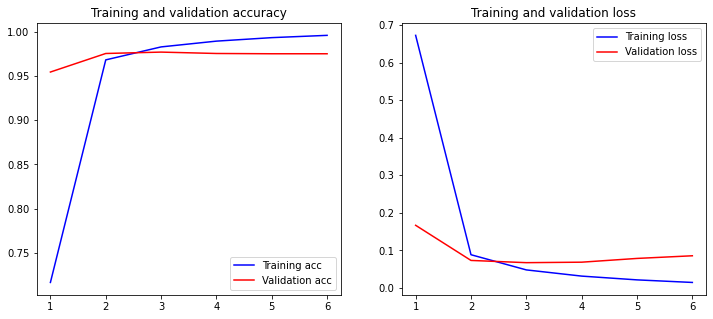

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
x = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x, acc, 'b', label='Training acc')
plt.plot(x, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x, loss, 'b', label='Training loss')
plt.plot(x, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Setelah selesai training, maka akurasi dan loss akan ditampilkan. Dengan model / arsitektur sederhana ini, model dapat mencapai validasi akurasi sampai 0.9750 dengan validasi lossnya sampai 0.0858.

## 2. c) Buatlah sebuah multi class classifier model menggunakan pre-trained model dan latihlah dataset sampai mendapatkan akurasi yang di inginkan. Jelaskan alasan kalian menggunakan pre-trained model yang kalian pilih

Untuk digunakan sebagai pembanding, pretrained model yang digunakan adalah pretrained model LSTM. 

Referensi yang saya gunakan untuk membuat model LSTM adalah : https://www.kaggle.com/code/atechnohazard/clickbait-classifier-using-lstm

Alasan saya memilih menggunakan pretrained model LSTM adalah model ini memiliki waktu training yang sangat cepat dibandingkan dengan model lainnya dan adanya kemampuan pretrained model untuk menghandle sequential data sehingga sangat cocok untuk natural language text. Selain itu, pada LSTM terdapat sebuah gerbang yang digunakan untuk meregulasi informasi yang masuk untuk menghandle vanishing gradient problem.

Saya sempat mencoba untuk melatih model dengan menggunakan bert, sayangnya model ini memiliki feature yang sangat berat dan sangat gpu demanding, dimana pada dataset clickbait.csv akan membutuhkan waktu 3 jam lebih untuk 1 epoch. Hasil yang didapat dengan menggunakan bert memang sangat bagus, tetapi karena terlalu resource dan time demanding maka tidak saya pakai.

In [20]:
def pretrained_lstm() :
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_size, input_length=maxlen))
    model.add(LSTM(32, return_sequences=True))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model
model2 = pretrained_lstm()
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm (LSTM)                  (None, 500, 32)           8320      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 168,353
Trainable params: 168,353
Non-trainable params: 0
_________________________________________________________________


LSTM sendiri atau (Long Short Term Memory) adalah salah satu arsitektur yang sudah sangat terkenal karena kemampuannya untuk menghadapi berbagai text classification problem (natural language processing).

LSTM terdiri dari beberapa layer, yaitu :

1. Embedding Layer, digunakan untuk mengubah token menjadi vector (embedding) dengan ukuran vectornya direpresentasikan dengan vector_size dan ukuran vocabularynya direpresentasikan dengan embedding size. Vocab size adalah jumlah unique word, embedding size adalah ukuran dense vector, input length adalah panjang maksimum dari sequence.

2. LSTM layer, adalah layer utama yang memanggil pretrained model LSTM pada arsitektur yang dibuat. Layer ini akan mengolah vector yang dihasilkan oleh embedding layer dan menghasilkan output dengan informasi memori serta context dari seluruh neuron.

3. Global max pooling 1 d layer, digunakan untuk mengambil nilai  maksimum sequence yang dihasilkan pada layer sebelumnya. 

4. Dropout layer, digunakan untuk menambahkan lapisan Dropout dengan tingkat 0,2, yang digunakan untuk mencegah overfitting dengan menyetel 20% unit input secara acak ke 0 selama proses training.

5. Dense layer, digunakan untuk menambahkan layer dense dengan satu unit dengan fungsi aktivasi sigmoid. Layer ini menampilkan probabilitas yang diprediksi dari kelas positif untuk menentukan apakah suatu teks termasuk dalam kelas positif atau negatif.

Setelah itu akan dideklarasikan model 2 adalah model yang menggunakan pretrained lstm dan ditampilkan summary dari model.

In [21]:
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        min_delta=1e-4,
        patience=3,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='uasNomor2c.h5',
        monitor='val_accuracy', 
        mode='max', 
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

Sama seperti pada model 1, akan dibuat fungsi callback. Fungsi ini digunakan memeriksa peningkatkan akurasi dari model, apabila tidak ada peningkatan, maka proses training akan dihentikkan untuk mengurangi redundansi.

Letak perbedaannya dengan fungsi callback pada model pertama adalah filepath yang ada pada modelcheckpoint.

Model akan dilatih sebanyak 20 epoch.

In [22]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history2 = model2.fit(X_train, y_train, batch_size=512, validation_data=(x_val, y_val), epochs=20, callbacks=callbacks)

Epoch 1/20


2023-02-06 13:30:46.270509: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


50/50 [==============================] - 5s 39ms/step - loss: 0.6570 - accuracy: 0.8333 - val_loss: 0.5566 - val_accuracy: 0.9578

Epoch 00001: val_accuracy improved from -inf to 0.95781, saving model to uasNomor2c.h5
Epoch 2/20
50/50 [==============================] - 1s 28ms/step - loss: 0.3521 - accuracy: 0.9522 - val_loss: 0.1856 - val_accuracy: 0.9631

Epoch 00002: val_accuracy improved from 0.95781 to 0.96312, saving model to uasNomor2c.h5
Epoch 3/20
50/50 [==============================] - 2s 33ms/step - loss: 0.1347 - accuracy: 0.9720 - val_loss: 0.1009 - val_accuracy: 0.9747

Epoch 00003: val_accuracy improved from 0.96312 to 0.97469, saving model to uasNomor2c.h5
Epoch 4/20
50/50 [==============================] - 1s 28ms/step - loss: 0.0866 - accuracy: 0.9800 - val_loss: 0.0812 - val_accuracy: 0.9778

Epoch 00004: val_accuracy improved from 0.97469 to 0.97781, saving model to uasNomor2c.h5
Epoch 5/20
50/50 [==============================] - 1s 28ms/step - loss: 0.0658 - accu

Memulai proses latihan.

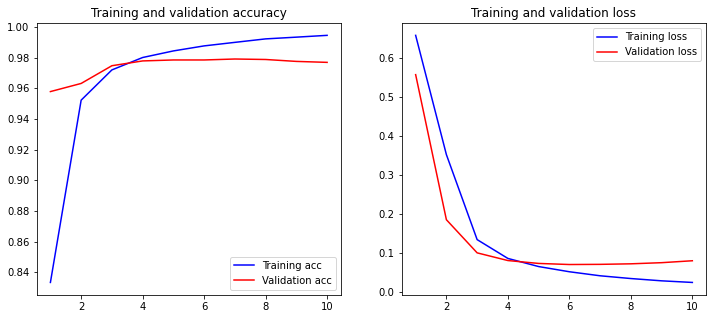

In [23]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
x = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x, acc, 'b', label='Training acc')
plt.plot(x, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x, loss, 'b', label='Training loss')
plt.plot(x, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Setelah selesai training, maka akurasi dan loss akan ditampilkan. Dengan model / arsitektur sederhana ini, model dapat mencapai validasi akurasi sampai 0.9769 dengan validasi lossnya sampai 0.0807.

## 2. d) Lakukan analisis performance pada dataset testing (cari nilai f-1-score, precision, recall dan accuracy) dari model yang dibuat dari 1b dan 1c. Berikan penjelasan mengenai hasil yang didapatkan dengan lengkap dan bandingkan hasil mana yang lebih baik?

Untuk membantu evaluasi performa dari model 1 dan model 2, saya menggunakan confusion matrix, f-1 score, precision, recall, dan accuracy. 

### Analisis Performa dari 1 b

In [24]:
preds = [round(i[0]) for i in model.predict(x_test)]

cm = confusion_matrix(y_test, preds)
print (cm)

[[1535   44]
 [  29 1592]]


In [25]:
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = 2*(precision*recall)/(precision+recall)
accuracy = (tp+tn)/(tp+tn+fp+fn)

print("Recall of the model is {:.4f}".format(recall))
print("Precision of the model is {:.4f}".format(precision))
print("F1 score of the model is {:.4f}".format(f1_score))
print("Accuracy score of the model is {:.4f}".format(accuracy))

Recall of the model is 0.9821
Precision of the model is 0.9731
F1 score of the model is 0.9776
Accuracy score of the model is 0.9772


### Analisis performa dari 1 c

In [26]:
preds = [round(i[0]) for i in model2.predict(x_test)]

cm2 = confusion_matrix(y_test, preds)
print (cm2)

[[1548   31]
 [  53 1568]]


In [27]:
tn, fp, fn, tp = cm2.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = 2*(precision*recall)/(precision+recall)
accuracy = (tp+tn)/(tp+tn+fp+fn)

print("Recall of the model is {:.4f}".format(recall))
print("Precision of the model is {:.4f}".format(precision))
print("F1 score of the model is {:.4f}".format(f1_score))
print("Accuracy score of the model is {:.4f}".format(accuracy))

Recall of the model is 0.9673
Precision of the model is 0.9806
F1 score of the model is 0.9739
Accuracy score of the model is 0.9738


Penjelasan dari recall, precision, f1 score, accuracy saya dapat dari referensi : https://medium.com/analytics-vidhya/confusion-matrix-accuracy-precision-recall-f1-score-ade299cf63cd.

F1 Score adalah rata-rata harmonik dari precision dan recall, mengukur kualitas pemodelan binary classification dengan menggabungkan kebaikan dari precision dan recall.

Precision mengukur proporsi prediksi positif yang benar dalam semua prediksi positif.

Recall mengukur proporsi observasi yang benar yang ditemukan oleh model dalam semua observasi yang sebenarnya positif.

Accuracy mengukur proporsi prediksi yang benar dari total observasi.

Semua empat metrik memiliki nilai antara 0 dan 1, dengan nilai 1 menunjukkan hasil terbaik dan nilai 0 hasil terburuk.

Dari kedua hasil yang didapat, apabila dirangkum :

Original Model
- Recall    = 0.9821
- Precision = 0.9731
- F1 score  = 0.9776
- Accuracy  = 0.9772


Pretrained Model
- Recall    = 0.9673
- Precision = 0.9806
- F1 score  = 0.9739
- Accuracy  = 0.9738

Kedua model memiliki hasil yang sangat mirip dan hanya berbeda 0.0 sekian saja. Kedua model juga memiliki hasil yang sangat bagus dimana semua angkanya lebih dari 0.96. Untuk keefektifan model sendiri saya lebih mendukung pretrained model, hal ini dikarenakan walaupun hasil yang didapat sangat mirip, pretrained model LSTM memiliki jumlah parameter layer yang jauh lebih sedikit dengan original model, pretrained model juga memakan waktu yang jauh pada saat pelatihan model. Oleh karena itu, menurut saya pretrained model LSTM lebih superior.